# Model Arima for Time Series Forecasting temperature

## LLibreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# Preparació de dades

In [2]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head(5)


,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80


In [3]:
# Intentem unificar les dades en promig de cada 6 hores.
# Es a dir, fem un dataframe on les dades que afegirem sera el promig del valor cada 6 hores. Per tant serà una entrada a les 6h, 12h, 18h i 24h.
# Respectant els horaris de les dades originals seria, per cada dia, interval de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59.

# Convertim la columna 'data' a datetime si no ho està
# df['data'] = pd.to_datetime(df['data'])

# Assignem cada registre al seu interval corresponent de 6 hores
# Els intervals seran: 00:00-05:59, 06:00-11:59, 12:00-17:59 i 18:00-23:59
df['interval_6h'] = df['data'].dt.floor('6H')

# Creem un nou dataframe agrupant les dades per intervals de 6 hores i calculant el promig
df_agrupades = df.groupby('interval_6h', as_index=False)['valor'].mean()

# Canviem el nom de la columna de data per mantenir la coherència
df_agrupades.rename(columns={'interval_6h': 'data'}, inplace=True)

# Ordenem el dataframe per data
df_agrupades = df_agrupades.sort_values(by='data').reset_index(drop=True)

# Mostrem les primeres files per verificar el resultat
df_agrupades.head(5)

,data,valor
0,1998-01-01 00:00:00+00:00,-5.38
1,1998-01-01 06:00:00+00:00,-4.73
2,1998-01-01 12:00:00+00:00,-1.98
3,1998-01-01 18:00:00+00:00,-1.80
4,1998-01-02 00:00:00+00:00,-2.07


## Graficació Sèrie Temporal

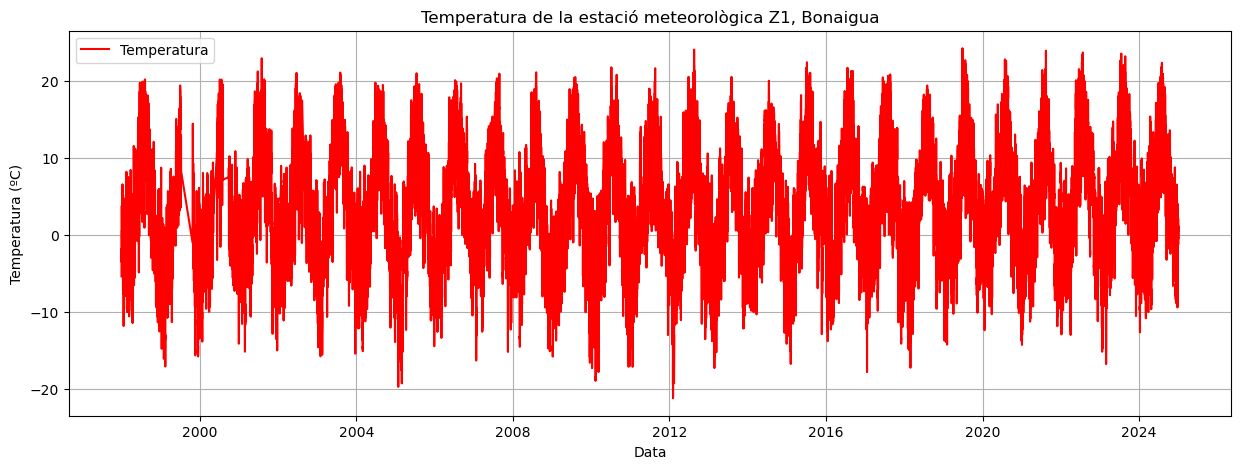

In [4]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df_agrupades['data'], df_agrupades['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


In [5]:
import plotly.express as px

# Crear un gràfic interactiu amb Plotly
fig = px.line(df_agrupades, x='data', y='valor', 
              title='Temperatura de la estació meteorològica Z1, Bonaigua',
              labels={'data': 'Data', 'valor': 'Temperatura (ºC)'})

# Millorar el disseny del gràfic
fig.update_traces(line=dict(color='red', width=2))

# Afegir opcions d'interactivitat i disseny
fig.update_layout(
    title_font=dict(size=20, family='Arial', color='black'),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    xaxis=dict(tickformat='%d %b %Y', tickangle=45),  # Format de data i rotació de l'eix x
    template='plotly',  # Estil fosc (canvia'l per 'plotly' per a un estil més clar)
    hovermode='x unified'  # Mostra totes les dades associades a la data en el mateix punt
)

# Mostrar el gràfic
fig.show()


# Construcció model ARIMA

In [9]:
# Dades pel model ARIMA

data = df_agrupades.copy()

# Assignem per entrenar el model les dades fins el 2020, fem servir separador anual
# Fins el 2020 (inclòs) entrenarem el model, del 2021 fins final, que es 2024 (inclòs) farem el test

# Assignem data límit pel dataframe de train i pel de test. Ho fem en el format datetime
data_tall = pd.to_datetime('2020-12-31 23:59:59+00:00')


# Assignem el conjunt de train
data_train = data[data['data'] <= data_tall]
# data_train.index = pd.to_datetime(data_train.index)

# Assignem el conjunt de test
data_test = data[data['data'] > data_tall]


In [7]:
data_train

,data,valor
0,1998-01-01 00:00:00+00:00,-5.38
1,1998-01-01 06:00:00+00:00,-4.73
2,1998-01-01 12:00:00+00:00,-1.98
3,1998-01-01 18:00:00+00:00,-1.80
4,1998-01-02 00:00:00+00:00,-2.07
...,...,...
32524,2020-12-30 18:00:00+00:00,-7.84
32525,2020-12-31 00:00:00+00:00,-7.98
32526,2020-12-31 06:00:00+00:00,-6.33
32527,2020-12-31 12:00:00+00:00,-5.77


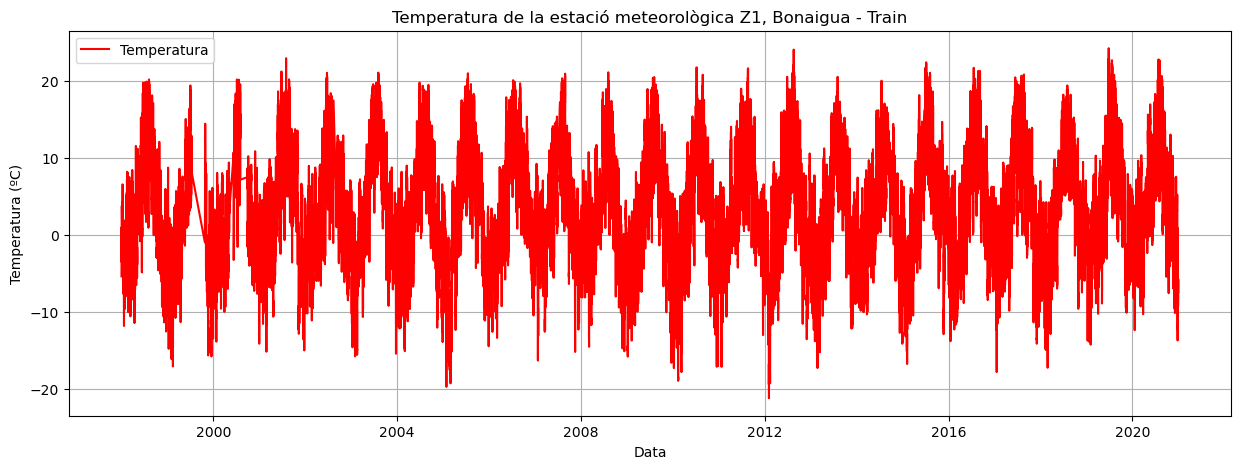

In [8]:
# Plot de la serie data_train
plt.figure(figsize=(15, 5))
plt.plot(data_train['data'], data_train['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua - Train')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()

KeyError: 'forecast'

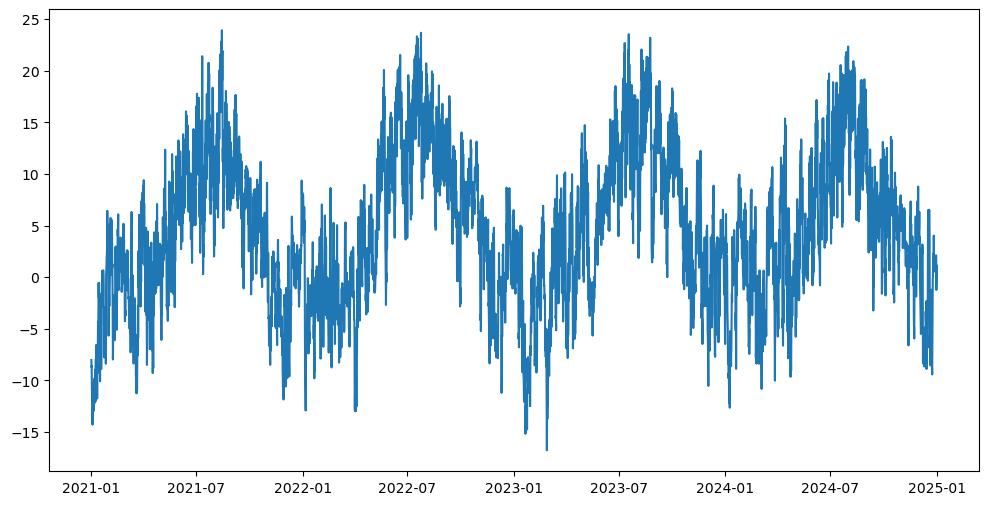

In [6]:
# rmse = mean_squared_error(data_test['valor'], data_test['forecast'], squared=False)
# print(f"RMSE: {rmse:.2f}")

# Gràfic
plt.figure(figsize=(12,6))
plt.plot(data_test['data'], data_test['valor'], label='Real')
plt.plot(data_test['data'], data_test['forecast'], label='Predicció')
plt.title('Predicció de temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = auto_arima(
    data_train['valor'],
    seasonal=True,
    m=4,  # estacionalitat diürna (4 valors de 6h = 24h)
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)
print(model.summary())

# Tests per establir els parametres del model

Results of Dickey-Fuller Test:
ADF Statistic: -8.575752
p-value: 0.000000


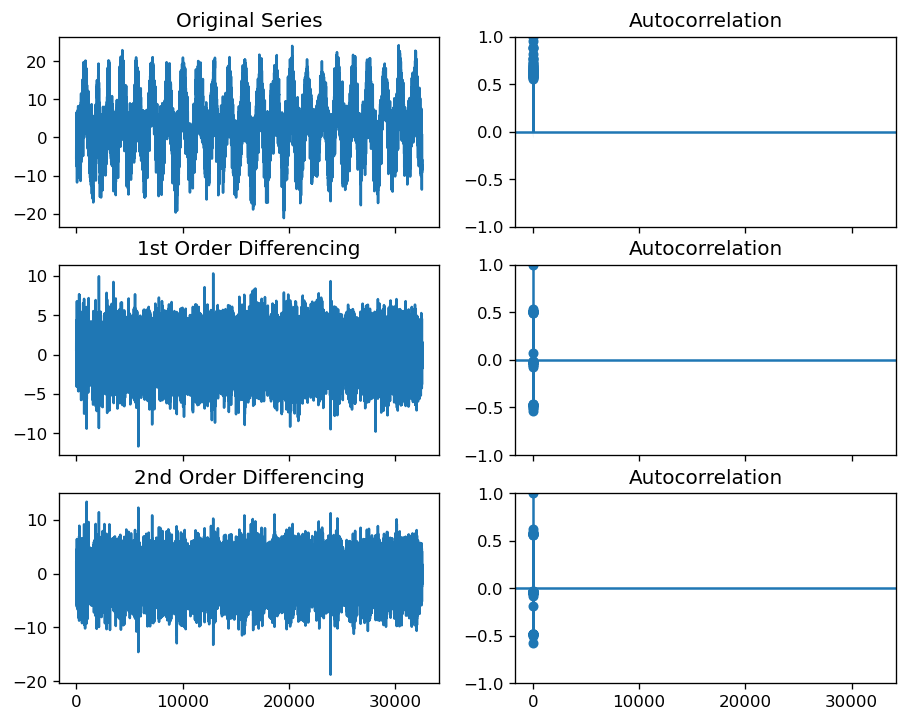

In [24]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(data_train['valor'].dropna())
print('Results of Dickey-Fuller Test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data_train['valor']); axes[0, 0].set_title('Original Series')
plot_acf(data_train['valor'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data_train['valor'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data_train['valor'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data_train['valor'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data_train['valor'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()


Com que el p-valor es inferior a 0.05 i el test de Dickey-Fuller ens indica que la sèrie es estacinonaria, per tant:

- d = 0

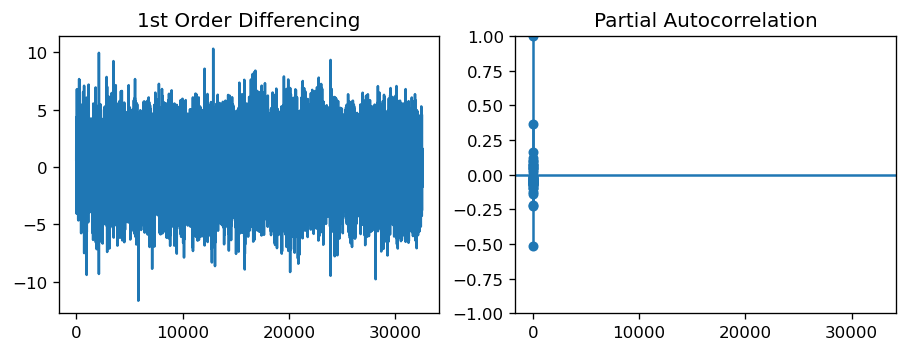

In [9]:
# Seleccio parametre p

# Per seleccionar el parametre P necessitem fer el Partial Autocorrelation Function (PACF)
# El PACF ens indica la correlació parcial entre una observació i les seves observacions anteriors, eliminant l'efecte de les observacions intermitges.
# El PACF ens ajuda a determinar l'ordre de l'auto-regressió (p) en un model ARIMA.

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_train['valor'].diff()); axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0, 5))
plot_pacf(data_train['valor'].diff().dropna(), ax=axes[1])

plt.show()

Establim doncs p = 1 per que la PAC te un pic a 1


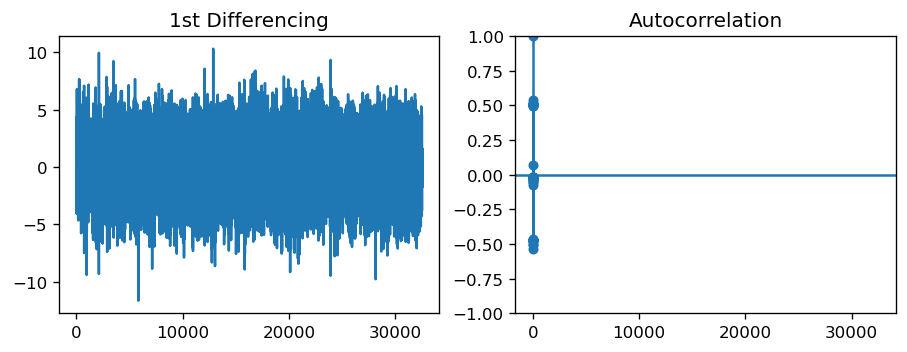

In [10]:
# Seleccio parmaetre q

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data_train['valor'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data_train['valor'].diff().dropna(), ax=axes[1])

plt.show()

Escollim doncs q = 1

# Creació del model 2

In [ ]:
# Definim els paràmetres p, d i q

# Ordre de l'auto-regressió
p = 1

# Ordre de la diferenciació
d = 0

# Ordre de la mitjana mòbil  
q = 1  

# Afegim p dades del conjunt de train al conjunt de test per iniciar la predicció
data_test = pd.concat([data_train[-p:], data_test])
data_test['data'].sort_values()

data_test.head(10)


,data,valor
32528,2020-12-31 18:00:00+00:00,-7.47
32529,2021-01-01 00:00:00+00:00,-8.02
32530,2021-01-01 06:00:00+00:00,-8.70
32531,2021-01-01 12:00:00+00:00,-8.59
32532,2021-01-01 18:00:00+00:00,-10.33
32533,2021-01-02 00:00:00+00:00,-11.00
32534,2021-01-02 06:00:00+00:00,-10.33
32535,2021-01-02 12:00:00+00:00,-12.08
32536,2021-01-02 18:00:00+00:00,-14.27
32537,2021-01-03 00:00:00+00:00,-14.28


In [12]:
# Creem el model ARIMA
model = ARIMA(data_train['valor'], order=(p, d, q))

# Ajustem el model
model = model.fit()

# Mostrem el resum del model ajustat
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                32529
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -72257.594
Date:                Tue, 22 Apr 2025   AIC                         144523.187
Time:                        13:22:40   BIC                         144556.747
Sample:                             0   HQIC                        144533.914
                              - 32529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0007      0.196     15.297      0.000       2.616       3.385
ar.L1          0.9078      0.002    381.252      0.000       0.903       0.913
ma.L1          0.3863      0.005     70.923      0.0

In [13]:
# Guardem el model ajustat
model.save('model_arima.pkl')

In [ ]:
# Carreguem el model ajustat
from statsmodels.tsa.arima.model import ARIMAResults
model = ARIMAResults.load('model_' \
'arima.pkl')

In [33]:
data_test

,data,valor
32528,2020-12-31 18:00:00+00:00,-7.47
32529,2021-01-01 00:00:00+00:00,-8.02
32530,2021-01-01 06:00:00+00:00,-8.70
32531,2021-01-01 12:00:00+00:00,-8.59
32532,2021-01-01 18:00:00+00:00,-10.33
...,...,...
38368,2024-12-30 18:00:00+00:00,0.03
38369,2024-12-31 00:00:00+00:00,-1.22
38370,2024-12-31 06:00:00+00:00,0.08
38371,2024-12-31 12:00:00+00:00,1.16


In [16]:
# Predicció de tota la serie temporal

# Realitzem la predicció 
# Funcio get_prediction() retorna un objecte PredictionResults on tambe s'inclouen els intervals de confiança i altres estadístiques
# Si nomes volguessim la predicció, podríem utilitzar la funció predict() que retorna un array amb les prediccions

# Realitzem la predicció utilitzant get_prediction() que inclou els intervals de confiança

type(data_test['valor'])


KeyError: 'valor'

In [ ]:
# data_test.index = pd.to_datetime(data_test.index)
start_date = data_test.index[0]  # Primer registre del conjunt de test
end_date = data_test.index[15]  # Últim registre del conjunt de test



# Realitzem la predicció
predictions = model.get_prediction(start=start_date, end=end_date, dynamic=True)

# Obtenim les prediccions i els intervals de confiança
predicted_value = predictions.predicted_mean  # Prediccions puntuals
conf_int = predictions.conf_int()  # Intervals de confiança

# Afegim les prediccions al DataFrame de test
data_test['predicted_values'] = predicted_value
data_test['predicted_lower'] = conf_int['lower valor']  # Interval inferior
data_test['predicted_upper'] = conf_int['upper valor']  # Interval superior

# Afegim les columnes d'error
# data_test['error'] = data_test['valor'] - data_test['predicted_values']
# data_test['error_squared'] = data_test['error'] ** 2
# data_test['error_absolute'] = data_test['error'].abs()
# data_test['error_absolute_squared'] = data_test['error_absolute'] ** 2

# # Mostrem les primeres files del dataframe amb les prediccions
data_test.head(10)


In [ ]:
data_test.sample(10)

In [ ]:

# Plotem els resultats
plt.figure(figsize=(15, 5))
# plt.plot(data_test['valor'], label='Observat', color='blue')
plt.plot(data_test['data'], data_test['valor'], label='Observat', color='blue')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Plot predicció

plt.figure(figsize=(15, 5))
plt.plot(data_test['data'], data_test['predicted_values'], label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Plot de de X valor anteriors del dataset data_train
d2 = data_train[-p:]
plt.figure(figsize=(15, 5))
plt.plot(d2['data'], d2['valor'], label='Dades anteriors', color='green')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Mateix plot pero ens fixem nomes en 2015

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

any = '2021'

plt.style.use("seaborn-v0_8-darkgrid")  # Millora l'estil del gràfic

fig, ax = plt.subplots(figsize=(15, 5))

# Gràfica de dades observades
ax.plot(data['valor'][any], label='Observat', color='#1f77b4', linewidth=2, alpha=0.8)

# Gràfica de la predicció
ax.plot(predicted_value[any], label='Predicció', color='#d62728', linestyle='dashed', linewidth=2)

# Gràfica de l'interval de confiança
# ax.fill_between(data.index[any], data['predicted_lower'][any],data['predicted_upper'][any], color='gray', alpha=0.2, label='Interval de confiança')


# Format de la graella i de les dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format curt de mes i any
plt.xticks(rotation=45)

# Etiquetes i títol
plt.title(f'Predicció de la temperatura amb ARIMA {any}', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (ºC)', fontsize=12)

# Llegenda i grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [ ]:
# Valorem el RMSE i MAE
# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(data['valor'], predicted_value))
print('RMSE:', rmse)

# Calcula el MAE
mae = mean_absolute_error(data['valor'], predicted_value)
print('MAE:', mae)

# Calcula el MSE
mse = mean_squared_error(data['valor'], predicted_value)
print('MSE:', mse)


In [ ]:
# Plot dels errors
plt.figure(figsize=(15, 5))
plt.plot(data['error'], label='Error', color='red')
plt.title('Error de la predicció')
plt.xlabel('Data')
plt.ylabel('Error (ºC)')
# plt.xlim('Jan 01 2022', 'Dec 31 2022')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Predir del 2025 fins al març del 2026
# Definim el rang de dates per a la predicció amb el mateix format que el dataframe original
start_date = '2025-01-01'
end_date = '2026-03-31'

# Convertim les dates a datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Realitzem la predicció
predictions_future = model.get_prediction(start=start_date, end=end_date, dynamic=False)

